In [1]:
import numpy as np
np.random.seed(123)

# data
from tensorflow.keras.datasets import mnist

# plot
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import BallTree
from sklearn.neighbors import KDTree

from IPython.display import clear_output

# from numba import njit

In [2]:
# load data
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

# resize each image from 28 x 28 to vector and normalize to maximum 1
train_data = train_data.reshape(train_data.shape[0], 28*28) / 255
test_data = test_data.reshape(test_data.shape[0], 28*28) / 255

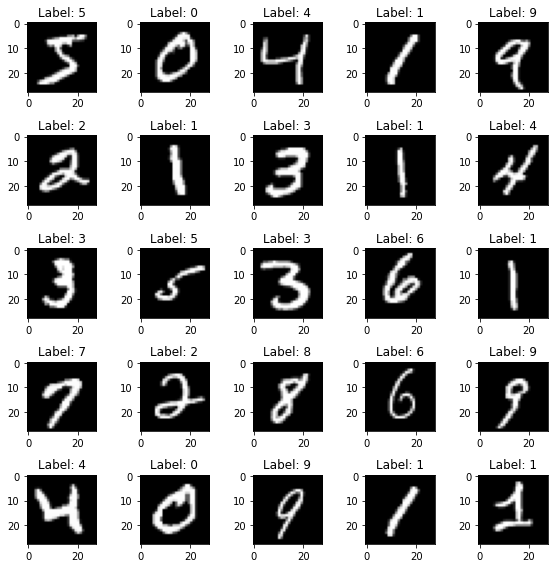

In [3]:
# show data
plt.figure(figsize=[8, 8])
rows, columns = 5, 5

for i in range(rows*columns):
    plt.subplot(rows,columns,i+1)
    plt.title("Label: %i"%train_labels[i])
    plt.imshow(train_data[i].reshape(28, 28), cmap='gray')
    
plt.tight_layout()
plt.show()

Euclidean distance between two vectors $x, y \in \mathbb{R}^{d}$ given by

$$\begin{align}
    \| x - y \| = \sqrt{\sum_{i=1}^d (x_i - y_i)^2}
\end{align}$$

Given a matrix of training data $Y \in \mathbb{R}^{n \times d}$
$$\begin{align}
    Y = \begin{bmatrix}
        y_{1, 1} & \ldots & y_{1, d} \\
        \vdots   & \ddots & \vdots    \\
        y_{n, 1} & \ldots & y_{n, d}
    \end{bmatrix}
    = \begin{bmatrix}
        — & (y^{(1)})^T & — \\
        \vdots & \vdots  & \vdots \\
        — & (y^{(n)})^T & — \\
    \end{bmatrix},
\end{align}$$

the nearest neighbor is defined as
$$\begin{align}
\newcommand{\argmin}{\arg\!\min}
    NN(x, Y) &= \left\{ m : \|x - y^{(m)}\| \ge \|x - y^{(j)}\|, \; \forall j \le n \right\} \\
    &= \operatorname*{argmin}_{j \in \{0, ..., n\}} \left\{ \| x - y^{(j)} \| \right\} \\
    &= \operatorname*{argmin}_{j \in \{0, ..., n\}} \left\{ \| x - y^{(j)} \|^2 \right\}.
\end{align}$$


In [4]:
def index_NN(x, Y=train_data):
    '''
    Parameters
    ----------
    k : number of nearest neighbors
    
    x : vector to predict
    
    train_data : training data
    '''
    
    # squared difference
    sq_diff = np.square(x - Y)

    # sum of squared (squared Euclidean distance)
    ssd = sq_diff.sum(axis=1)

    # find minimum distance
    argmin = np.argmin(ssd)
    
    # return index
    return argmin


def NN_predict(X, Y=train_data, Y_label=train_labels):
    '''
    Parameters
    ----------
    X : matrix of predict data
    
    train_data : training data
    '''
    pred_indices = np.zeros(X.shape[0])

    for i, x in enumerate(X):

        pred_indices[i] = index_NN(x, Y)
        
    return train_labels[pred_indices.astype(int)]

In [5]:
%%time

# number of data points to test
m = 500

# get data and labels
data, labels = test_data[:m], test_labels[:m]

# get predicted indices
nn_predictions = NN_predict(data)

# find errors
correct = (labels == nn_predictions)

# calculate accuracy
accuracy = np.sum(correct) / len(data)
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 96.60%
Wall time: 2min


K-Nearest Neighbors:

$$\begin{align}
    KNN(x, Y) = \{m\}_{m=0}^{k} \quad s.t. \quad \|x - y^{m}\| \ge \|x - y^{j}\| \quad \forall j \le n, m \le k
\end{align}$$

In [6]:
def index_KNN(k, x, Y=train_data):
    '''
    Parameters
    ----------
    k : number of nearest neighbors
    
    x : vector to predict
    
    train_data : training data
    '''
    
    # squared difference
    sq_diff = np.square(x - Y)

    # sum of squared (squared Euclidean distance)
    ssd = sq_diff.sum(axis=1)

    # find minimum distance
    argmins = np.argsort(ssd)[:k]
    
    # return index
    return argmins.astype(int)

def KNN_predict(k=1, X, Y=train_data, Y_label=train_labels):
    
    pred = np.zeros((X.shape[0], k))

    for i, x in enumerate(X):

        # predicted k labels
        pred[i] = train_labels[index_KNN(k, x, Y)]
    
    return pred

In [40]:
def get_mode(array):

    vals, counts = np.unique(array, return_counts=True)
    mode_index = np.argmin(counts)
    mode = vals[mode_index]

    return mode

In [22]:
%%time

# number of data points to test
m = 500

# get data and labels
data, labels = test_data[:m], test_labels[:m]

# get predicted indices
k = 1
knn_predictions = KNN_predict(k, data)

# find errors
correct = (labels == [get_mode(row) for row in knn_predictions])

# calculate accuracy
accuracy = np.sum(correct) / np.product(data.shape)
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 5118.40%
Wall time: 2min 32s


In [23]:
%%time
# Build nearest neighbor structure on training data
ball_tree = BallTree(train_data)

Wall time: 36.8 s


In [24]:
%%time
# Get nearest neighbor predictions on testing data
neighbors = np.squeeze(ball_tree.query(data, k=k, return_distance=False))
ball_tree_predictions = train_labels[neighbors]

# check same results
same = np.sum(np.equal(ball_tree_predictions, knn_predictions), axis=0) / np.product(knn_predictions.shape)
print(f'Same: {same:.2%}')

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [20]:
%%time
# Build nearest neighbor structure on training data
kd_tree = KDTree(train_data)

Wall time: 40.8 s


In [21]:
%%time
# Get nearest neighbor predictions on testing data
neighbors = np.squeeze(kd_tree.query(data, k=5, return_distance=False))
kd_tree_predictions = train_labels[neighbors]

# check results
same = np.sum(np.equal(kd_tree_predictions, knn_predictions), axis=1) / np.product(knn_predictions.shape)
print(f'Same: {same:.2%}')

TypeError: unsupported format string passed to numpy.ndarray.__format__